Instalacion de PyCUDA

In [ ]:
!apt-get update
!apt-get install -y nvidia-cuda-toolkit
!pip install pycuda

Get:1 https://cli.github.com/packages stable InRelease [3,917 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://cli.github.com/packages stable/main amd64 Packages [345 B]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [83.6 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,202 kB]
Get:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,519 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-backp

Descargar el MNIST

In [ ]:
!mkdir -p data/mnist
!wget -q https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz -O data/mnist/train-images.gz
!wget -q https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz -O data/mnist/train-labels.gz
!wget -q https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz -O data/mnist/t10k-images.gz
!wget -q https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz -O data/mnist/t10k-labels.gz
!gunzip data/mnist/*.gz


Renombrar

In [ ]:
!mv data/mnist/train-images data/mnist/train-images-idx3-ubyte
!mv data/mnist/train-labels data/mnist/train-labels-idx1-ubyte
!mv data/mnist/t10k-images data/mnist/t10k-images-idx3-ubyte
!mv data/mnist/t10k-labels data/mnist/t10k-labels-idx1-ubyte


Creacion del Kernel

In [ ]:
%%writefile cuda_kernels.py
from pycuda.compiler import SourceModule

kernel_code = r"""
extern "C" __global__
void matmul_naive(const float* A, const float* B, float* C,
                  int M, int N, int K)
{
    // A: M x N
    // B: N x K
    // C: M x K

    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row >= M || col >= K) return;

    float sum = 0.0f;

    for (int i = 0; i < N; i++) {
        sum += A[row * N + i] * B[i * K + col];
    }

    C[row * K + col] = sum;
}
"""

mod = SourceModule(kernel_code)
matmul_naive = mod.get_function("matmul_naive")


Writing cuda_kernels.py


Funciones para lanzar el kernel

In [ ]:
%%writefile gpu_ops.py
import pycuda.autoinit
import pycuda.driver as cuda
import numpy as np
from cuda_kernels import matmul_naive

def gpu_matmul(A: np.ndarray, B: np.ndarray):
    """
    Multiplicación de matrices en GPU usando el kernel naive.
    A: (M x N)
    B: (N x K)
    Return: C (M x K)
    """

    M, N = A.shape
    N2, K = B.shape
    assert N == N2, "Dimensiones incompatibles"

    # Crear matriz de salida
    C = np.zeros((M, K), dtype=np.float32)

    # Crear eventos para profiling
    start_htod = cuda.Event()
    end_htod = cuda.Event()
    start_kernel = cuda.Event()
    end_kernel = cuda.Event()
    start_dtoh = cuda.Event()
    end_dtoh = cuda.Event()

    # Reservar memoria Device
    A_gpu = cuda.mem_alloc(A.nbytes)
    B_gpu = cuda.mem_alloc(B.nbytes)
    C_gpu = cuda.mem_alloc(C.nbytes)

    # Transferir Host → Device
    start_htod.record()
    cuda.memcpy_htod(A_gpu, A)
    cuda.memcpy_htod(B_gpu, B)
    end_htod.record()

    # Definir bloques 16x16
    block_size = (16, 16, 1)
    grid_size = ((K + 15) // 16, (M + 15) // 16)

    # Ejecutar kernel
    start_kernel.record()
    matmul_naive(
        A_gpu, B_gpu, C_gpu,
        np.int32(M), np.int32(N), np.int32(K),
        block=block_size, grid=grid_size
    )
    end_kernel.record()

    # Device → Host
    start_dtoh.record()
    cuda.memcpy_dtoh(C, C_gpu)
    end_dtoh.record()

    # Sincronizar y calcular tiempos
    end_htod.synchronize()
    end_kernel.synchronize()
    end_dtoh.synchronize()

    time_htod = start_htod.time_till(end_htod)  # milliseconds
    time_kernel = start_kernel.time_till(end_kernel) # milliseconds
    time_dtoh = start_dtoh.time_till(end_dtoh) # milliseconds

    return C, {"htod": time_htod, "kernel": time_kernel, "dtoh": time_dtoh}

Writing gpu_ops.py


Version en GPU del MLP

In [ ]:
%%writefile mlp_gpu.py
import numpy as np
from gpu_ops import gpu_matmul

class MLP_GPU:
    def __init__(self, input_dim=784, hidden_dim=512, output_dim=10, seed=42):
        rng = np.random.default_rng(seed)

        self.W1 = rng.normal(0, np.sqrt(2/(input_dim+hidden_dim)),
                             size=(input_dim, hidden_dim)).astype(np.float32)
        self.b1 = np.zeros((1, hidden_dim), dtype=np.float32)

        self.W2 = rng.normal(0, np.sqrt(2/(hidden_dim+output_dim)),
                             size=(hidden_dim, output_dim)).astype(np.float32)
        self.b2 = np.zeros((1, output_dim), dtype=np.float32)

    # ---------- FORWARD ----------
    def forward(self, X):
        # GPU GEMM: Z1 = X @ W1
        Z1_np, matmul1_times = gpu_matmul(X, self.W1)
        Z1 = Z1_np + self.b1

        A1 = np.maximum(Z1, 0)

        # GPU GEMM: Z2 = A1 @ W2
        Z2_np, matmul2_times = gpu_matmul(A1, self.W2)
        Z2 = Z2_np + self.b2

        Z2_shift = Z2 - Z2.max(axis=1, keepdims=True)
        exp_scores = np.exp(Z2_shift)
        probs = exp_scores / exp_scores.sum(axis=1, keepdims=True)

        cache = {
            "X": X, "Z1": Z1, "A1": A1, "probs": probs,
            "matmul1_times": matmul1_times, "matmul2_times": matmul2_times
        }
        return probs, cache

    # ---------- LOSS ----------
    def compute_loss(self, probs, Y):
        eps = 1e-8
        return float(-np.sum(Y * np.log(probs + eps)) / Y.shape[0])

    # ---------- BACKWARD ----------
    def backward(self, cache, probs, Y):
        batch = Y.shape[0]
        X = cache["X"]
        A1 = cache["A1"]
        Z1 = cache["Z1"]

        dZ2 = (probs - Y) / batch
        dW2_np, dW2_times = gpu_matmul(A1.T, dZ2)
        dW2 = dW2_np
        db2 = dZ2.sum(axis=0, keepdims=True)

        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * (Z1 > 0)
        dW1_np, dW1_times = gpu_matmul(X.T, dZ1)
        dW1 = dW1_np
        db1 = dZ1.sum(axis=0, keepdims=True)

        return {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2, "backward_times": {"dW1_times": dW1_times, "dW2_times": dW2_times}}

    # ---------- UPDATE ----------
    def step(self, grads, lr=1e-2):
        self.W1 -= lr * grads["dW1"].astype(np.float32)
        self.b1 -= lr * grads["db1"].astype(np.float32)
        self.W2 -= lr * grads["dW2"].astype(np.float32)
        self.b2 -= lr * grads["db2"].astype(np.float32)

    def predict(self, X):
        probs, _ = self.forward(X)
        return np.argmax(probs, axis=1)

    def accuracy(self, X, Y):
        probs, _ = self.forward(X)
        preds = np.argmax(probs, axis=1)
        labels = np.argmax(Y, axis=1)
        return float((preds == labels).mean())

Writing mlp_gpu.py


Train

In [ ]:
%%writefile train_pycuda.py
import argparse
import time
import numpy as np
from mlp_gpu import MLP_GPU
from data_loader import load_mnist

def iterate_minibatches(X, Y, batch_size, shuffle=True):
    n = X.shape[0]
    idx = np.arange(n)
    if shuffle:
        np.random.shuffle(idx)

    for start in range(0, n, batch_size):
        end = min(start + batch_size, n)
        i = idx[start:end]
        yield X[i], Y[i]

def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--data-root", type=str, default="data/mnist")
    parser.add_argument("--epochs", type=int, default=5)
    parser.add_argument("--batch-size", type=int, default=256)
    parser.add_argument("--hidden-dim", type=int, default=512)
    parser.add_argument("--lr", type=float, default=0.01)
    parser.add_argument("--seed", type=int, default=42)
    args = parser.parse_args()

    X_train, Y_train, X_test, Y_test = load_mnist(args.data_root)

    mlp = MLP_GPU(hidden_dim=args.hidden_dim, seed=args.seed)

    total_htod_times = []
    total_kernel_times = []
    total_dtoh_times = []

    start_time = time.time()

    for epoch in range(1, args.epochs + 1):
        epoch_loss = 0
        batches = 0

        for Xb, Yb in iterate_minibatches(X_train, Y_train, args.batch_size):
            probs, cache = mlp.forward(Xb)
            loss = mlp.compute_loss(probs, Yb)
            grads = mlp.backward(cache, probs, Yb)
            mlp.step(grads, args.lr)

            # Collect times from forward pass
            total_htod_times.append(cache["matmul1_times"]["htod"])
            total_kernel_times.append(cache["matmul1_times"]["kernel"])
            total_dtoh_times.append(cache["matmul1_times"]["dtoh"])

            total_htod_times.append(cache["matmul2_times"]["htod"])
            total_kernel_times.append(cache["matmul2_times"]["kernel"])
            total_dtoh_times.append(cache["matmul2_times"]["dtoh"])

            # Collect times from backward pass
            total_htod_times.append(grads["backward_times"]["dW1_times"]["htod"])
            total_kernel_times.append(grads["backward_times"]["dW1_times"]["kernel"])
            total_dtoh_times.append(grads["backward_times"]["dW1_times"]["dtoh"])

            total_htod_times.append(grads["backward_times"]["dW2_times"]["htod"])
            total_kernel_times.append(grads["backward_times"]["dW2_times"]["kernel"])
            total_dtoh_times.append(grads["backward_times"]["dW2_times"]["dtoh"])

            epoch_loss += loss
            batches += 1

        epoch_loss /= batches
        train_acc = mlp.accuracy(X_train[:5000], Y_train[:5000])
        test_acc = mlp.accuracy(X_test, Y_test)

        print(f"Epoch {epoch}: loss={epoch_loss:.4f} train={train_acc:.4f} test={test_acc:.4f}")

    total = time.time() - start_time
    print(f"Entrenamiento GPU completado en {total:.2f} s")

    # Guardar tiempos en un archivo para el plotting
    np.savez("profiling_times.npz", htod=total_htod_times, kernel=total_kernel_times, dtoh=total_dtoh_times)

if __name__ == "__main__":
    main()

Overwriting train_pycuda.py


Archivo de data_loader.py


In [ ]:
%%writefile data_loader.py
import os
import struct
import numpy as np

def _read_idx_images(path: str):
    with open(path, 'rb') as f:
        magic, num, rows, cols = struct.unpack('>IIII', f.read(16))
        assert magic == 2051, f"Formato IDX imágenes inválido: {magic}"
        data = np.frombuffer(f.read(), dtype=np.uint8).reshape((num, rows * cols))
        return data.astype(np.float32) / 255.0

def _read_idx_labels(path: str, num_classes: int = 10):
    with open(path, 'rb') as f:
        magic, num = struct.unpack('>II', f.read(8))
        assert magic == 2049, f"Formato IDX labels inválido: {magic}"
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        one_hot = np.zeros((num, num_classes), dtype=np.float32)
        one_hot[np.arange(num), labels] = 1.0
        return one_hot

def load_mnist(data_root: str, use_bin: bool = False):
    X_train = _read_idx_images(os.path.join(data_root, 'train-images-idx3-ubyte'))
    Y_train = _read_idx_labels(os.path.join(data_root, 'train-labels-idx1-ubyte'))
    X_test = _read_idx_images(os.path.join(data_root, 't10k-images-idx3-ubyte'))
    Y_test = _read_idx_labels(os.path.join(data_root, 't10k-labels-idx1-ubyte'))
    return X_train, Y_train, X_test, Y_test


Overwriting data_loader.py


Ejecutar el entrenamiento

In [ ]:
!python train_pycuda.py --data-root data/mnist --epochs 10 --batch-size 1024


Epoch 1: loss=2.4175 train=0.0530 test=0.0575
Epoch 2: loss=2.3572 train=0.0830 test=0.0906
Epoch 3: loss=2.3201 train=0.1118 test=0.1201
Epoch 4: loss=2.2886 train=0.1398 test=0.1480
Epoch 5: loss=2.2602 train=0.1640 test=0.1757
Epoch 6: loss=2.2346 train=0.1918 test=0.2026
Epoch 7: loss=2.2123 train=0.2250 test=0.2300
Epoch 8: loss=2.1914 train=0.2510 test=0.2599
Epoch 9: loss=2.1721 train=0.2740 test=0.2854
Epoch 10: loss=2.1553 train=0.2964 test=0.3106
Entrenamiento GPU completado en 9.72 s


Generar Grafica de profiling

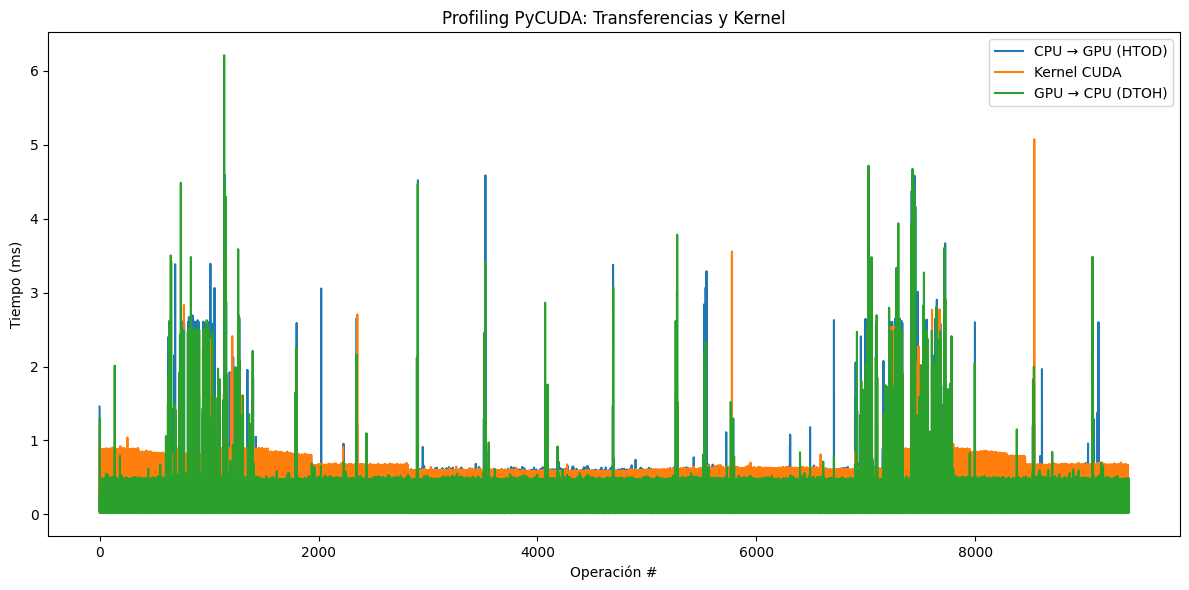

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def main():
    data = np.load("profiling_times.npz")

    htod = data["htod"]
    kernel = data["kernel"]
    dtoh = data["dtoh"]

    plt.figure(figsize=(12,6))
    plt.plot(htod, label="CPU → GPU (HTOD)")
    plt.plot(kernel, label="Kernel CUDA")
    plt.plot(dtoh, label="GPU → CPU (DTOH)")

    plt.xlabel("Operación #")
    plt.ylabel("Tiempo (ms)")
    plt.title("Profiling PyCUDA: Transferencias y Kernel")
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
